# Pengenalan Pola

## Lab 1: Distribusi Gaussian dan Naive Bayes

Praktikum ini merupakan materi penunjang pertemuan ketiga dan keempat. Anda diasumsikan sudah mempunyai sedikit pengalaman menggunakan NumPy untuk mengolah matriks serta matplotlib dan seaborn untuk mengolah grafik. Dataset yang digunakan adalah data digit yang tersedia dari pustaka [scikit-learn](http://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_digits.html).

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

%matplotlib inline

sns.set_context('talk')

In [2]:
from sklearn.datasets import load_digits

# Memuat data
data = load_digits()

In [3]:
# Membagi data menjadi atribut dan kelas
X = data['data']
y = data['target']

### Pendahuluan

Sebagai permulaan, mari mencoba untuk membandingkan dua angka saja terlebih dahulu: 2 dan 4. Kita akan menggunakan notasi matriks $M_{ij}$ untuk menggambarkan nilai pixel pada posisi baris ke-i dan kolom ke-j dari gambar.

Kita akan menggambarkan rata-rata nilai tiap pixel untuk angka 2 dan 4. Lalu, coba perhatikan pixel $M_{02}$ dan $M_{46}$ dari gambar angka 2 (kiri) dan 4 (kanan). Apakah Anda dapat menemukan perbedaannya?

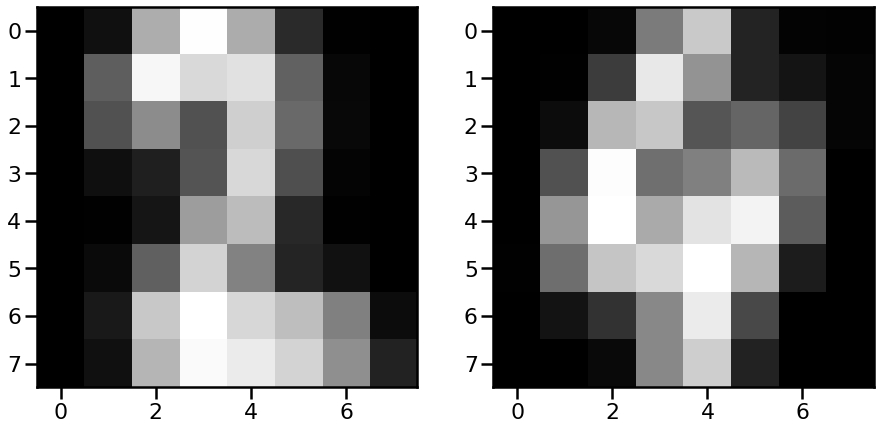

In [4]:
fig, ax = plt.subplots(ncols=2, figsize=(15,7))
ax[0].imshow(X[y == 2].mean(axis=0).reshape(8,8), cmap='gray')
ax[1].imshow(X[y == 4].mean(axis=0).reshape(8,8), cmap='gray');

Bagian atas kiri (*top left*) dari angka 2 kemungkinan akan "menyala", sedangkan di tengah kanan (*mid right*) akan *cenderung* "mati", i.e. tidak ada coretan pembentuk angka 2. Sebaliknya, angka 4 akan "mati" di atas kiri dan "menyala" di tengah kanan. Untuk memudahkan analisis kita sementara ini, kita akan memfokuskan pada dua pixel ini saja.

### Distribusi Gaussian dari Nilai Pixel

Sebetulnya, berapa kemungkinan pixel atas kiri akan menyala? Berapa pula kemungkinan pixel tengah kanan akan menyala? Nilai ini dapat kita hitung probabilitasnya dengan mengasumsikan bahwa nilainya akan terdistribusi normal/Gaussian.

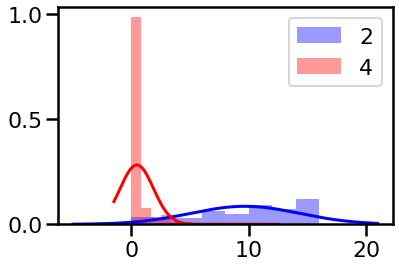

In [5]:
from scipy.stats import norm

sns.distplot(X[y == 2][:,2], kde=False, hist_kws={'color': 'b'}, fit=norm, fit_kws={'color': 'b'}, label='2')
sns.distplot(X[y == 4][:,2], kde=False, hist_kws={'color': 'r'}, fit=norm, fit_kws={'color': 'r'}, label='4')
plt.legend();

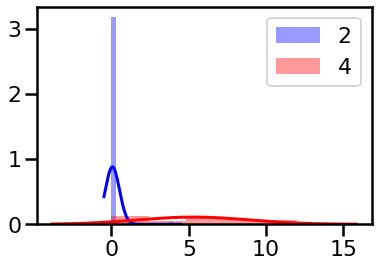

In [6]:
sns.distplot(X[y == 2][:,38], kde=False, hist_kws={'color': 'b'}, fit=norm, fit_kws={'color': 'b'}, label='2')
sns.distplot(X[y == 4][:,38], kde=False, hist_kws={'color': 'r'}, fit=norm, fit_kws={'color': 'r'}, label='4')
plt.legend();

Perhatikan dua grafik di atas. Kecenderungan yang kita asumsikan tadi ternyata terlihat dari histogram dan distribusi normal yang kita cocokkan ke histogram tersebut. Pada dasarnya, kita menghitung MLE dari distribusi Gaussian dari data yang kita punya. Dengan kata lain, kita menghitung

$$
\hat{\mu} = \frac{1}{N}\sum_{i=1}^N x_i
$$
dan
$$
\hat{\sigma}^2 = \frac{1}{N}\sum_{i=1}^N (x_i - \mu)^2
$$

Dalam kode, Anda dapat melakukannya dengan berbagai cara seperti contoh di bawah ini. Misalkan kita akan menghitung $\hat{\mu}$ dan $\hat{\sigma}^2$ dari nilai $M_{02}$.

In [7]:
x = X[y == 2][:,2] # nilai M02 dari kelas 2

print('Dengan library SciPy:')
mu, sigma = norm.fit(x)
print('μ = {:.2f}'.format(mu))
print('σ = {:.2f}'.format(sigma))

print()

print('Dengan rumus di atas untuk menghitung MLE:')
print('μ = {:.2f}'.format(x.mean()))
print('σ = {:.2f}'.format(x.std()))

Dengan library SciPy:
μ = 9.67
σ = 4.65

Dengan rumus di atas untuk menghitung MLE:
μ = 9.67
σ = 4.65


### Multivariate Gaussian

Mari kita coba melihat kedua atribut tersebut secara bersamaan. Apakah polanya akan lebih terlihat? Untuk mengetahui hal tersebut, kita dapat mengasumsikan bahwa kedua atribut tersebu akan mengikuti distribusi Gaussian untuk dua variabel, i.e. bivariate Gaussian.

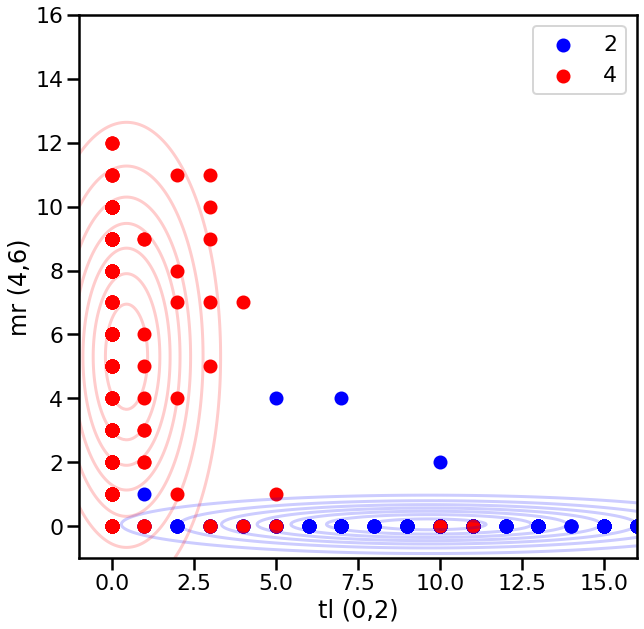

In [9]:
from scipy.stats import multivariate_normal

fig, ax = plt.subplots(figsize=(10,10))
tl = np.linspace(-1, 16, 500)
mr = np.linspace(-1, 16, 500)

cmaps = ['Blues', 'Reds']
for angka, c in zip([2, 4], cmaps):
    cov = np.cov(np.vstack([X[y == angka,2], X[y == angka,38]]))
    cov[0,1] = 0
    cov[1,0] = 0
    mvn = multivariate_normal([X[y == angka,2].mean(), X[y == angka,38].mean()], cov)

    x1, x2 = np.meshgrid(tl, mr)
    pos = np.dstack([x1, x2])

    color = c[0].lower()
    z = mvn.pdf(pos)
    ax.contour(x1, x2, z, alpha=.2, colors=color)
    ax.scatter(X[y == angka,2], X[y == angka,38], c=color, label=angka)
    ax.set_xlabel('tl (0,2)')
    ax.set_ylabel('mr (4,6)')
plt.legend();

Pada grafik di atas, kita menggunakan asumsi naif dari Naive Bayes sehingga nilai matriks kovariansinya (*covariance matrix*) adalah

$$
\Sigma = \begin{bmatrix}
\Sigma_{11} & 0 \\ 
0 & \Sigma_{22}
\end{bmatrix}
$$

yang sering diseebut juga dengan nama *diagonal covariance matrix*. Dampaknya, *contour plot* di atas menjadi sejajar sumbu (*axis-aligned*).

Asumsi tersebut dapat dilunakkan dengan menggunakan *full covariance matrix* seperti di bawah ini.

$$
\Sigma = \begin{bmatrix}
\Sigma_{11} & \Sigma_{12} \\ 
\Sigma_{21} & \Sigma_{22}
\end{bmatrix}
$$

Perhatikan baris 9 pada kode di bawah ini. Fungsi tersebut adalah untuk menghitung matriks kovariansi dari kedua variabel. Jika Anda taruh kedua grafik bertumpukan, maka Anda akan dapat melihat bahwa *contour plot* di bawah terlihat lebih miring.

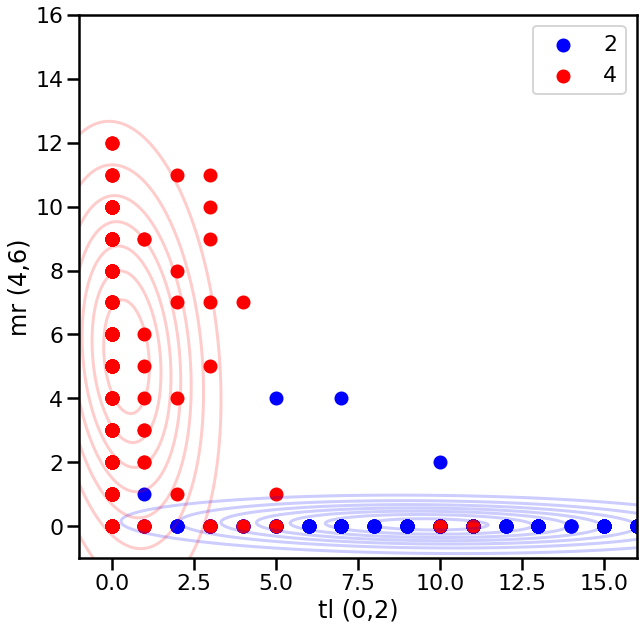

In [10]:
fig, ax = plt.subplots(figsize=(10,10))
tl = np.linspace(-1, 16, 500)
mr = np.linspace(-1, 16, 500)

cmaps = ['Blues', 'Reds']
for angka, c in zip([2, 4], cmaps):
    cov = np.cov(np.vstack([X[y == angka,2], X[y == angka,38]]))
    mvn = multivariate_normal([X[y == angka,2].mean(), X[y == angka,38].mean()], cov)

    x1, x2 = np.meshgrid(tl, mr)
    pos = np.dstack([x1,x2])

    color = c[0].lower()
    z = mvn.pdf(pos)
    ax.contour(x1, x2, z, alpha=.2, colors=color)
    ax.scatter(X[y == angka,2], X[y == angka,38], c=color, label=angka)
    ax.set_xlabel('tl (0,2)')
    ax.set_ylabel('mr (4,6)')
plt.legend();

Ingat kembali bahwa nilai
\begin{align}
\Sigma_{12} = \Sigma_{21} &= \mathbb{E}[(X_1 - \mu_1)(X_2 - \mu_2)] \\
                          &= \mathbb{E}[X_1 X_2] - \mu_1 \mu_2
\end{align}

Bukti:
\begin{align}
\Sigma_{12} &= \mathbb{E}[(X_1 - \mu_1)(X_2 - \mu_2)] \\
&= \mathbb{E}[X_1 X_2 - X_1 \mu_2 - X_2 \mu_1 + \mu_1 \mu_2] \\
&= \mathbb{E}[X_1 X_2] - \mathbb{E}[X_1 \mu_2] - \mathbb{E}[\mu_1 X_2] + \mathbb{E}[\mu_1 \mu_2] \\
&= \mathbb{E}[X_1 X_2] - \mu_2 \mathbb{E}[X_1] - \mu_1 \mathbb{E}[X_2] + \mu_1 \mu_2 \\
&= \mathbb{E}[X_1 X_2] - \mu_2 \mu_1 - \mu_1 \mu_2 + \mu_1 \mu_2 \\
&= \mathbb{E}[X_1 X_2] - \mu_1 \mu_2 \\
\end{align}

In [12]:
x1 = X[y == 2][:,2]
x2 = X[y == 2][:,38]
print('Σ11 = {:.4f}'.format(x1.var()))
print('Σ12 = {:.4f}'.format(np.dot(x1-x1.mean(), x2-x2.mean())/len(x1)))
print('Σ22 = {:.4f}'.format(x2.var()))

Σ11 = 21.6573
Σ12 = -0.2109
Σ22 = 0.2052
